# SmartAds job test

Sarana Maksym's solution

## Task

Assume we’ve got a high load bidder which performs on-line click prediction. The target is bidding on the bid requests which lead to the click with the biggest probability. At the attachment you’ve got educational and control logs of the parsed and processed bid requests with the click target value. Your purpose is build the model which predicts the clicks in the best way.

The task is:

1. Process educational logs
2. Build the click prediction model
3. Validate the model
4. Apply click prediction for the control set bid requests
5. Measure the time
6. Post your code at the GitHub

N.B.:

- The educational log data is serialized in msgpack_numpy format and encoded in base64 format 
- The maximal time for prediction shouldn’t be greater than 10 mls. 
- The prediction model should permit the realtime education 
- The model should be easily accessed for realtime bidding


## Solution

Imports:

In [478]:
import pandas as pd
import msgpack_numpy as m
import numpy as np
import base64
import random
import time
import os
import commands
import math

from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

As datasets are relative small, I'll load the data into Pandas DataFrame:

In [9]:
def convDF(data):
    for clm in data.columns:
        data[clm] = data[clm].map(lambda x: x[x.find(':')+1:])
    data['requestValue'] = data['requestValue'].map(lambda x: m.unpackb(base64.decodestring(x)))
    data.index = data['requestID']
    for i in range(0, 525):
        data['V_'+str(i)] = data['requestValue'].map(lambda x: x['bid_request_body'][i])
    for i in range(0, 2):
        data['F_'+str(i)] = data['requestValue'].map(lambda x: x['weight_funnel_stage_0'][i])
    data.drop(['requestID', 'requestValue'], inplace=True, axis=1)
    if 'click' in data.columns:
        data['click'] = data['click'].map(lambda x: int(x))

raw_train = pd.read_table('edu.log', sep = '|', header=None, names = ["requestID","requestValue","click"])

convDF(raw_train)

raw_train

,click,V_0,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,...,V_517,V_518,V_519,V_520,V_521,V_522,V_523,V_524,F_0,F_1
requestID,,,,,,,,,,,,,,,,,,,,,
34-d91ba231397e48aabaf6f35eb47016e6,0,0.0,0.0,19997003.0,57.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,70395263.0,100274130.0,0.0,0.0,0.0,8965,2389
152-406A70020FFC2BBC5BC969FC1E344AAB,0,0.0,0.0,52669052.0,213.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,75128266.0,10773024.0,0.0,0.0,0.0,8965,2389
34-1c3b9d4cf54c42adb0e1dc8797f386ec,0,0.0,0.0,20530698.0,293.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2058778.0,0.0,0.0,0.0,8965,2389
34-24c78e7b21c34e009d8a9896976f79f8,0,0.0,0.0,19997003.0,57.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,256389514.0,264283846.0,0.0,0.0,0.0,8965,2389
34-b90166270e1d4f5aa6ed9dbe4601d615,0,0.0,0.0,54211958.0,318.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,236551568.0,52546098.0,0.0,0.0,0.0,8965,2389
34-39ce55388288491e98537dbfa355c835,1,0.0,0.0,186380827.0,180.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,23850682.0,0.0,0.0,0.0,8965,2389
34-2827a979bb2d4faaa589caec224d262c,0,0.0,0.0,20530698.0,293.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,58798369.0,0.0,0.0,0.0,8965,2389
152-C5E825735F42B27832459840E22F3A6C,0,0.0,0.0,35576330.0,155.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,49228425.0,0.0,0.0,0.0,8965,2389
152-451A1504BA00092786850D816D81C854,0,0.0,0.0,52669052.0,213.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,20201255.0,0.0,0.0,0.0,8965,2389


In [10]:
raw_test = pd.read_table('predict.log', sep = '|', header=None, names = ["requestID","requestValue"])
convDF(raw_test)
raw_test

,V_0,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,...,V_517,V_518,V_519,V_520,V_521,V_522,V_523,V_524,F_0,F_1
requestID,,,,,,,,,,,,,,,,,,,,,
105-BF4F9DC5A23B96EEE597E2F81B783C33,0.0,0.0,52669052.0,148.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,245006992.0,0.0,0.0,0.0,7657,1844
34-5c75a18e4b9c49aca29bef5c35ff4b5a,0.0,0.0,4815498.0,378.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,219642172.0,229073018.0,0.0,0.0,0.0,8965,2389
34-efe345d7686c4390a0c3449299f1941b,0.0,0.0,100202074.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,39236484.0,207501745.0,0.0,0.0,0.0,8978,2389
9-7852545B5D236BD51392633103347AA8,0.0,0.0,261235455.0,178.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,50795756.0,178667477.0,0.0,0.0,0.0,8965,2389
34-f5e1bdc866224ea9905b1afe695b44cf,0.0,0.0,100202074.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,39236484.0,207501745.0,0.0,0.0,0.0,8978,2389
34-baf9f1bf2f104167920047cf86640989,0.0,0.0,80643485.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,47518451.0,223332568.0,0.0,0.0,0.0,8965,2389
34-c5709550a5be4b8cb015dbf09b204c4e,0.0,0.0,80643485.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,47518451.0,223332568.0,0.0,0.0,0.0,8965,2389
10-CB4A0F431EF9917567EF5E519F944EF2,0.0,0.0,35576330.0,155.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,238713132.0,107368126.0,0.0,0.0,0.0,8965,2389
9-2B32FDF05F89983EA43C131BFE66A66F,0.0,0.0,147764070.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,107277378.0,139580684.0,0.0,0.0,0.0,7657,1844


### Brief exploratory analysis

Let's look at datasets' size:

In [269]:
[raw_train.shape, raw_test.shape]

[(67141, 528), (31314, 527)]

How unbalanced is the target variable?

In [300]:
(raw_train['click'].mean(), raw_train['click'].sum())

(0.028611429677842155, 1921)

There only 1921 clicks in the train DS, or less 3%. Classes are strongly unbalanced.

Test whether there are duplicate entries (DataFrame.index doesn't garantee that):

In [272]:
(len(raw_train.index.unique()) != len(raw_train.index), len(raw_test.index.unique()) != len(raw_test.index))

(False, False)

Test whether there are common entries in the train and test datasets:

In [274]:
set(raw_train.index) & set(raw_test.index)

set()

Are there null values?

In [322]:
(raw_train.isnull().sum().sum(), raw_test.isnull().sum().sum())

(0, 0)

Now let's look how sparse the features are:

In [290]:
def getZeroNonZeroColumns(data):
    zz, nz = set(), set()
    
    for c in [x for x in data.columns if x != 'click']:
        if data[c] .any():
            nz.add(c)
        else:
            zz.add(c)
    
    return zz, nz
        
zz_train, nz_train = getZeroNonZeroColumns(raw_train)
zz_test, nz_test = getZeroNonZeroColumns(raw_test)

In [293]:
print 'Zero columns in the train DS:', len(zz_train)
print 'Zero columns in the test DS:', len(zz_test)
print 'Non-zero columns in the train DS:', len(nz_train)
print 'Non-zero columns in the test DS:', len(nz_test)

Zero columns in the train DS: 448
Zero columns in the test DS: 450
Non-zero columns in the train DS: 79
Non-zero columns in the test DS: 77


Is there difference between datasets?

In [291]:
zz_train ^ zz_test

{'V_174', 'V_399'}

These columns have zero values in the test DS only

Columns with data:

In [296]:
raw_train[list(nz_train)].describe()

,V_389,V_521,V_380,V_382,V_385,V_384,V_386,V_52,V_53,V_50,...,V_320,V_408,V_409,V_406,F_0,V_405,V_262,V_332,V_174,V_62
count,67141.000000,6.714100e+04,6.714100e+04,67141.0,67141.000000,67141.000000,67141.000000,6.714100e+04,67141.0,67141.000000,...,6.714100e+04,6.714100e+04,6.714100e+04,67141.000000,67141.000000,67141.000000,67141.000000,6.714100e+04,67141.000000,6.714100e+04
mean,59.830059,1.328157e+08,7.862401e+07,6.0,7.959324,2.999955,3.976944,1.521288e+08,3.0,6.144418,...,3.529625e+07,1.487477e+08,1.474480e+08,0.311997,8067.168317,133.323305,0.038665,6.434334e+07,0.000015,1.005866e+08
std,43.236670,7.743048e+07,8.053218e+07,0.0,0.450993,0.017686,0.261987,8.115453e+07,0.0,1.124153,...,7.114980e+07,1.718868e+07,1.128978e+08,0.162048,869.419722,53.108744,0.192796,6.414005e+07,0.003859,9.900772e+07
min,50.000000,1.629700e+04,1.818900e+05,6.0,1.000000,0.000000,1.000000,2.418390e+05,3.0,1.200000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.050000,6232.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,50.000000,6.490031e+07,9.681261e+06,6.0,8.000000,3.000000,4.000000,7.400027e+07,3.0,6.400000,...,0.000000e+00,1.526980e+08,3.381532e+07,0.180000,7657.000000,120.000000,0.000000,4.086111e+07,0.000000,0.000000e+00
50%,50.000000,1.325901e+08,1.534237e+07,6.0,8.000000,3.000000,4.000000,1.411122e+08,3.0,6.400000,...,0.000000e+00,1.526980e+08,1.551209e+08,0.294500,8540.000000,120.000000,0.000000,4.086111e+07,0.000000,7.480974e+07
75%,50.000000,1.990975e+08,1.518651e+08,6.0,8.000000,3.000000,4.000000,2.390178e+08,3.0,6.400000,...,2.271166e+07,1.526980e+08,2.664131e+08,0.400000,8965.000000,120.000000,0.000000,4.086111e+07,0.000000,2.092382e+08
max,250.000000,2.684236e+08,2.683971e+08,6.0,8.000000,4.000000,4.000000,2.679357e+08,3.0,6.400000,...,2.679796e+08,1.526980e+08,2.664131e+08,0.899000,8980.000000,320.000000,1.000000,2.409285e+08,1.000000,2.682436e+08


Now let's look at columns with low number of unique values. Maybe there are categorical features there:

In [297]:
unique_count = raw_train[list(nz_train)].apply(lambda x: len(x.unique()),  axis=0)
ul10 = unique_count[unique_count < 10]
pd.DataFrame([ul10.index, ul10.index.map(lambda x: str(raw_train[x].unique()))], index=['Column','Values']).T

,Column,Values
0,V_389,[ 50. 250.]
1,V_382,[ 6.]
2,V_385,[ 8. 3. 1.]
3,V_384,[ 3. 0. 4.]
4,V_386,[ 4. 1.]
5,V_53,[ 3.]
6,V_50,[ 6.4 1.2]
7,V_51,[ 2.30239189e+08]
8,V_57,[ 0. 1.]
9,V_54,[ 4. 1. 5.]


Well, there is no problem with filds with one or two unique value, and there is no clear categorical pattern in others except F_1. Look more at the weight_funnel_stage_0 values:

In [304]:
(raw_train['F_0'].unique(), raw_train['F_1'].unique())

(array([8965, 8978, 8542, 7657, 8540, 7688, 8541, 8543, 6233, 6234, 6232,
        8544, 8545, 8980]), array([2389, 2194, 1844, 2195, 1268, 2397]))

These features can be categorical

## Sklearn probes

Now I'll try several ML algorithms from the sklearn library. They don't satisfy all task demands, but allow to see how algorithms work on this data

Dividing original train DS onto two parts (80/20):

In [312]:
srch_train, srch_test = train_test_split(raw_train, test_size=0.2, random_state=42, 
                                         stratify=raw_train.click)

At the beginning I'll use 5-fold validation to check models:

In [329]:
def kFoldValidation(data, prVal, modelParam={}):
    """
    Calculates predictions using 5-fold validation, prints ROC AUC matric.
    data - dataset
    prVal - function for fold prediction
    modelParam - dic with parameters
    """
    
    N_folds = 5
    
    skf = StratifiedKFold(data.click, n_folds=N_folds, shuffle=True, random_state=1234)
    
    res = []
    for train_index, test_index in skf:
        res.append(prVal(data.ix[data.index[train_index]], data.ix[data.index[test_index]], modelParam))
    res = np.concatenate(res, axis=1)    
    
    print 'ROC AUC =', roc_auc_score(res[0,:], res[1,:]),
        
    return res

### Logistic regression

In [451]:
def logisticRegr(train, test, modelParam = {}):
    model = LogisticRegression(**modelParam)
    model = model.fit(train.drop(['click'], axis=1), train['click'])

    predicted = model.predict_proba(test.drop(['click'], axis=1))
    
    res = np.array([test.click, predicted[:,np.dot([0, 1], model.classes_)]])
    return res

res = kFoldValidation(srch_train, logisticRegr)

ROC AUC = 0.898748743266


Now look at a contingency matrix for classification threshold = 0.5:

In [452]:
pd.crosstab(res[0,:], res[1,:] > 0.5, rownames=['Click'], colnames=['Prediction'])

Prediction,False,True
Click,,
0.0,52136,39
1.0,1514,23


Looks badly - huge number of unpredicted clicks (FN, type-II error) and very little for predicted ones. For this task type-I error is reletively more preferable because it's better to show an advertisement to user who won't click it instead don't show it to whom whould click. Having costs of each error (advertising costs and lost benefit) it's possible to calculate that proportion precisely.

The one way to fix that - choose another threshold. Now I'll plot some curves. We are interested in Recall (Recall = TP / (TP + FN), it high when FN low) that in Precision (Precision = TP / (TP + FP), it high when FP low).

In [453]:
def plotCurves(original, predicted_proba, F_alpha = 0.5):
    """
    Plots curves:
    - Recall
    - Precision
    - Specificity
    - F-score
    depending on threshold.
    F-score includes alpha parameter that sets proportion between Precision and Recall
    """
    
    res = pd.DataFrame(index = np.arange(0, 1.01, 0.01), columns=['Recall', 'Precision', 'Specificity', 'Fscore'])
    
    for i in res.index:
        tp = sum((original > 0) & (predicted_proba > i))
        tn = sum((original == 0) & (predicted_proba <= i))
        fp = sum((original == 0) & (predicted_proba > i))
        fn = sum((original > 0) & (predicted_proba <= i))
        p = tp / float(tp + fp)
        r = tp / float(tp + fn)
        res.Recall[i] = r
        res.Precision[i] = p
        res.Specificity[i] = tn / float(tn + fp)
        #res.F1[i] = (2.0 * p * r / (p + r))
        res.Fscore[i] = 1 / (F_alpha / p + (1 - F_alpha) / r)
 
    with plt.style.context('fivethirtyeight'):
        plt.figure(figsize=(12,8))
        plt.plot(res.index, res.Recall, label = 'Recall')
        plt.plot(res.index, res.Precision, label = 'Precision')
        plt.plot(res.index, res.Specificity, label = 'Specificity')
        plt.plot(res.index, res.Fscore, label = 'F-score (alpha=' + str(F_alpha) + ')')
        plt.legend()
        max_point = (res.Fscore.idxmax(), res.Fscore.max())
        plt.annotate('F-Score max ({:.3f}, {:.3f})'.format(*max_point), xy= max_point, xytext= max_point)
        plt.xlabel('Classification threshold')

    plt.show()

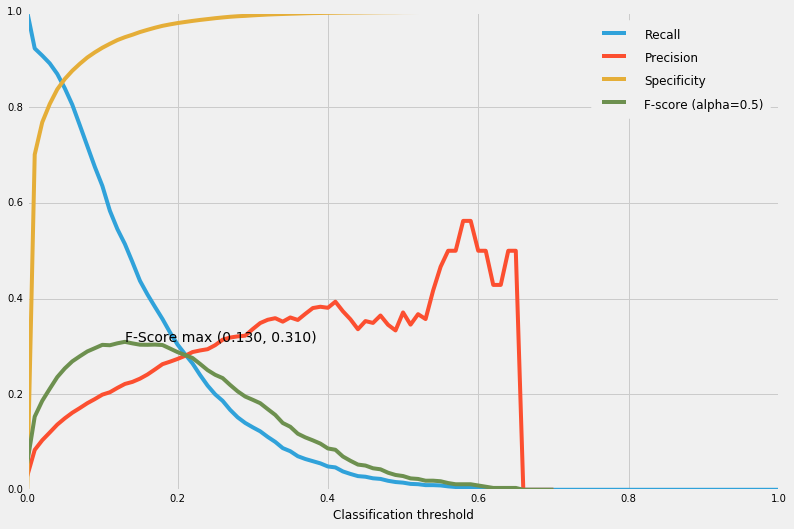

In [454]:
plotCurves(res[0,:], res[1,:])

Recall goes up if the threshold is very little. There metric that combine Recall and Precision - F-score. Changing alpha parameter we can choose the proportion of Recall and Precision. Let set, say, alpha = 0.1 (little impact of Precision and huge - of Recall):

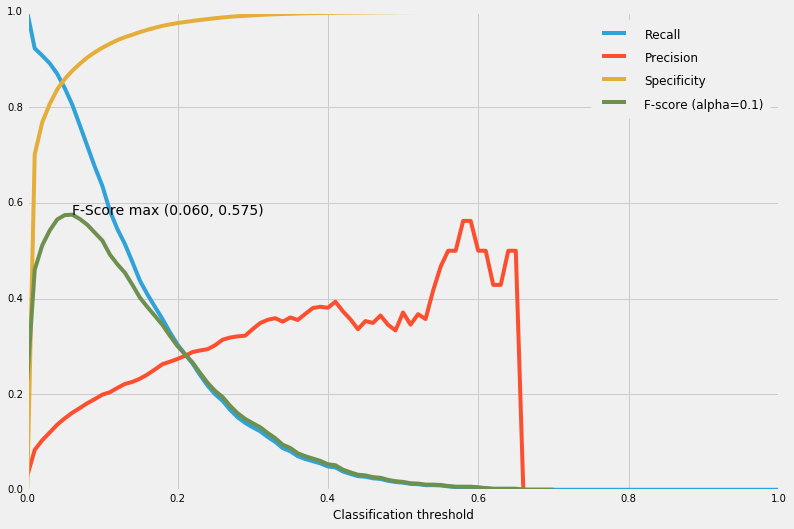

In [455]:
plotCurves(res[0,:], res[1,:], 0.1)

The F-score curve reaches maximum at threshold = 0.05. Let's look at the contingency matrix with that threshold:

In [457]:
pd.crosstab(res[0,:], res[1,:] > 0.06, rownames=['Click'], colnames=['Prediction'])

Prediction,False,True
Click,,
0.0,45734,6441
1.0,299,1238


FN looks much better, but FP have rocketed. Now look at prediction on new data:

In [458]:
res = logisticRegr(srch_train, srch_test)
pd.crosstab(res[0,:], res[1,:] > 0.06, rownames=['Click'], colnames=['Prediction'])

Prediction,False,True
Click,,
0.0,11383,1662
1.0,96,288


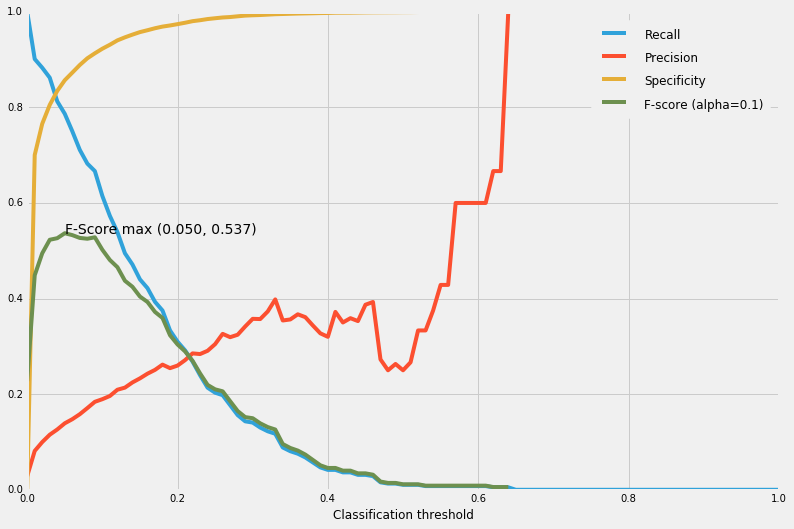

In [459]:
plotCurves(res[0,:], res[1,:], 0.1)

Time of prediction on the test DS:

In [460]:
model = LogisticRegression()
model = model.fit(raw_train.drop(['click'], axis=1), raw_train['click'])

predTime = time.time()
predicted = model.predict_proba(raw_test)
predTime = time.time() - predTime
print "Prediction time on test DS: {:.3f} ms".format(predTime * 1000)
print "Time per record: {:.3f} ms".format(predTime * 1000 / raw_test.shape[0])

Prediction time on test DS: 56.097 ms
Time per record: 0.002 ms


Now let's try some other algorithms:

### Naive Bayes

ROC AUC = 0.869879549923

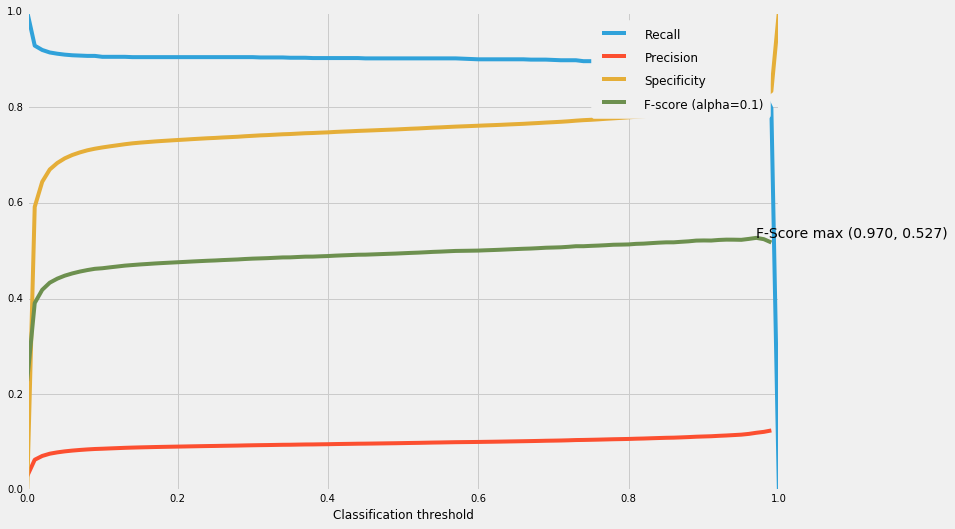

In [461]:
def NB(train, test, modelParam):
    model = GaussianNB(**modelParam)
    model = model.fit(train.drop(['click'], axis=1), train['click'])
    predicted = model.predict_proba(test.drop(['click'], axis=1))
    res = np.array([test.click, predicted[:,np.dot([0, 1], model.classes_)]])
    return res

res = kFoldValidation(srch_train, NB)
plotCurves(res[0,:], res[1,:], 0.1)

0.5-threshold contingency matrix:

In [463]:
pd.crosstab(res[0,:], res[1,:] > 0.5, rownames=['Click'], colnames=['Prediction'])

Prediction,False,True
Click,,
0.0,39364,12811
1.0,150,1387


0.97-threshold contingency matrix:

In [465]:
pd.crosstab(res[0,:], res[1,:] > 0.97, rownames=['Click'], colnames=['Prediction'])

Prediction,False,True
Click,,
0.0,42532,9643
1.0,231,1306


0.05-threshold contingency matrix:

In [466]:
pd.crosstab(res[0,:], res[1,:] > 0.05, rownames=['Click'], colnames=['Prediction'])

Prediction,False,True
Click,,
0.0,36174,16001
1.0,138,1399


That means NB is much more resistant to FN. What is we mix NB and LR?

### Naive Bayes + Logistic Regression

ROC AUC = 0.89595743268

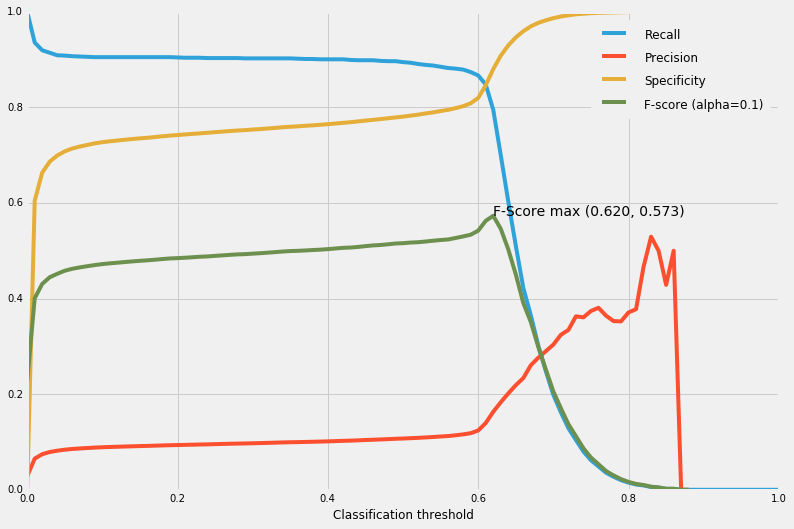

In [625]:
def NB_LR(train, test, modelParam):
    model1 = GaussianNB(*modelParam[0])
    model1 = model1.fit(train.drop(['click'], axis=1), train['click'])
    predicted1 = model1.predict_proba(test.drop(['click'], axis=1))
    predicted1 = predicted1[:,np.dot([0, 1], model1.classes_)]

    
    model2 = LogisticRegression(**modelParam[1])
    model2 = model2.fit(train.drop(['click'], axis=1), train['click'])
    predicted2 = model2.predict_proba(test.drop(['click'], axis=1))
    predicted2 = predicted2[:,np.dot([0, 1], model2.classes_)]

    
    return np.array([test.click, predicted1 * 0.6 + predicted2 * 0.4])

res = kFoldValidation(srch_train, NB_LR, [{}, {}])
plotCurves(res[0,:], res[1,:], 0.1)

In [470]:
pd.crosstab(res[0,:], res[1,:] > 0.62, rownames=['Click'], colnames=['Prediction'])

Prediction,False,True
Click,,
0.0,45910,6265
1.0,315,1222


### Random forest

RF regressor:

ROC AUC = 0.915832951702

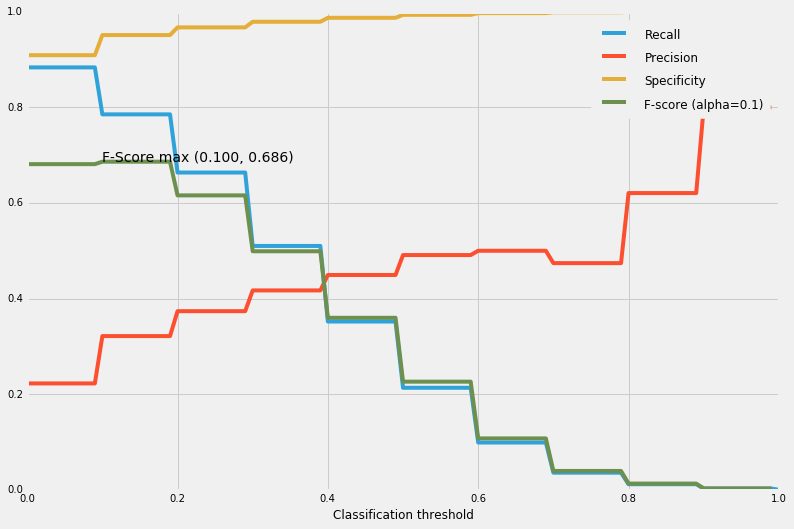

In [473]:
def RF(train, test, modelParam):
    model = RandomForestRegressor(**modelParam)
    model = model.fit(train.drop(['click'], axis=1), train['click'])
    predicted = model.predict(test.drop(['click'], axis=1))
    return np.array([test.click, predicted])

res = kFoldValidation(srch_train, RF)
plotCurves(res[0,:], res[1,:], 0.1)

In [474]:
pd.crosstab(res[0,:], res[1,:] > 0.15, rownames=['Click'], colnames=['Prediction'])

Prediction,False,True
Click,,
0.0,49628,2547
1.0,330,1207


RF classifier:

In [480]:
def RFC(train, test, modelParam):
    model = RandomForestClassifier(**modelParam)
    model = model.fit(train.drop(['click'], axis=1), train['click'])
    predicted = model.predict(test.drop(['click'], axis=1))
    return np.array([test.click, predicted])

res = kFoldValidation(srch_train, RFC)
pd.crosstab(res[0,:], res[1,:], rownames=['Click'], colnames=['Prediction'])

ROC AUC = 0.543942365276

Prediction,0,1
Click,,
0,51974,201
1,1396,141


Classifier has too high FN

### XGBoost

ROC AUC = 0.94832565446

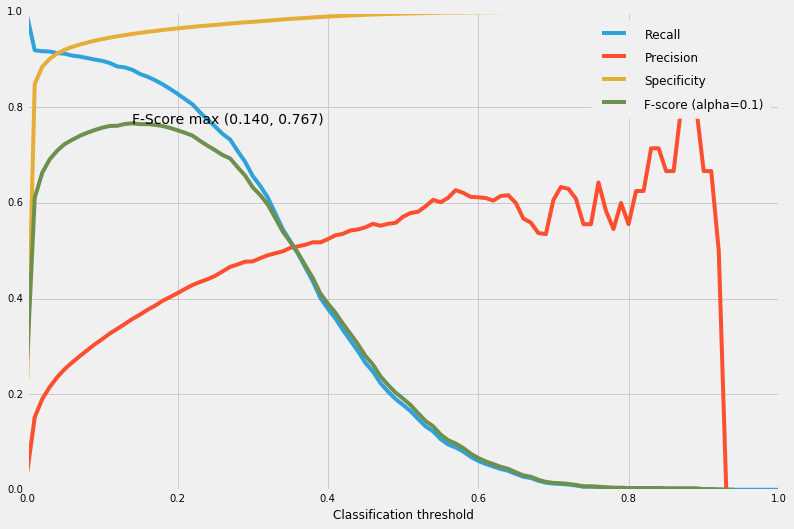

In [483]:
def XGB(train, test, modelParam):
    gbm = xgb.XGBRegressor(**modelParam).fit(train.drop(['click'], axis=1), train['click'])
    predicted = gbm.predict(test.drop(['click'], axis=1))
    return np.array([test.click, predicted])

res = kFoldValidation(srch_train, XGB, {'max_depth':4, 'n_estimators':500, 'learning_rate':0.05})
plotCurves(res[0,:], res[1,:], 0.1)

In [485]:
pd.crosstab(res[0,:], res[1,:] > 0.14, rownames=['Click'], colnames=['Prediction'])

Prediction,False,True
Click,,
0.0,49748,2427
1.0,187,1350


Testing on the new data (my test dataset - 20% of edu.log):

In [487]:
res = XGB(srch_train, srch_test, {'max_depth':4, 'n_estimators':500, 'learning_rate':0.05})
pd.crosstab(res[0,:], res[1,:] > 0.14, rownames=['Click'], colnames=['Prediction'])

Prediction,False,True
Click,,
0.0,12436,609
1.0,60,324


Prediction time:

In [489]:
model = xgb.XGBRegressor(**{'max_depth':4, 'n_estimators':500, 'learning_rate':0.05})
model = model.fit(raw_train.drop(['click'], axis=1), raw_train['click'])

predTime = time.time()
predicted = model.predict(raw_test)
predTime = time.time() - predTime
print "Prediction time on test DS: {:.3f} ms".format(predTime * 1000)
print "Time per record: {:.3f} ms".format(predTime * 1000 / raw_test.shape[0])

Prediction time on test DS: 1001.500 ms
Time per record: 0.032 ms


XGBoost is too long...

## Vowpal Wabbit

A function for converting data:

In [626]:
def convertDFtoVW(i, data):
    vw_row = ""
    if 'click' in data.columns and data.click[i] == 0:
        vw_row = "-1"
    else:
        vw_row = "1"
    vw_row += " '" +  i
    
    for c in [x for x in data.columns if x != 'click']:
        vw_row += "|" + c + " " + str(data[c][i]) + " "
    
    return vw_row + '\n'
   
def writeToVWFile(data, filename):
    fout = open(filename, 'wb')
    for i in data.index:
        fout.write(convertDFtoVW(i, data))
    fout.close()

Creating data files:

In [628]:
writeToVWFile(srch_train, 'srch_train.vw')
writeToVWFile(srch_test, 'srch_test.vw')
writeToVWFile(raw_train, 'train.vw')
writeToVWFile(raw_test, 'test.vw')

Create data-files for K-fold CV (1_fold_train.vw, 1_fold_test.vw, 2_fold_train.vw ...)

In [497]:
skf = StratifiedKFold(srch_train.click, n_folds=5, shuffle=True, random_state=1234)
    
i = 1
for train_index, test_index in skf:
    writeToVWFile(srch_train.ix[srch_train.index[train_index]], str(i) + "_fold_train.vw")
    writeToVWFile(srch_train.ix[srch_train.index[test_index]], str(i) + "_fold_test.vw")
    i += 1

In [591]:
def kFoldValidationVW(param, printOutput = False):
    """
    Calculates predictions using 5-fold validation, prints ROC AUC matric.
    data - dataset
    prVal - function for fold prediction
    modelParam - dic with parameters
    """

    res = []
    for i in range(1, 6):
        try:
            os.remove(str(i) + "_fold_model.vw")
        except OSError:
            pass
        s = commands.getoutput('vw %s -f %s %s'%(str(i) + "_fold_train.vw", str(i) + "_fold_model.vw", param))
        
        if printOutput:
            print('Fold ' + str(i) + '\n')
            print(s)
            print('\n')

        commands.getoutput('vw %s -t -i %s -p %s'%(str(i) + "_fold_test.vw", str(i) + "_fold_model.vw", str(i) + "_fold_pred.txt"))
        r = pd.read_table(str(i) + "_fold_pred.txt", sep=' ', header=None, )
        res.append(np.array([r[1].map(lambda x: raw_train.click[x]), r[0].map(lambda x: 1 / (1 + math.exp(-x)))]))
        
    res = np.concatenate(res, axis=1)   
    
    print 'ROC AUC =', roc_auc_score(res[0,:], res[1,:]),
        
    return res

In [592]:
res = kFoldValidationVW('--loss_function logistic', True)

Fold 1

final_regressor = 1_fold_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 1_fold_train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.0000      528
0.375134 0.057120            2            2.0  -1.0000  -2.8339      528
0.199531 0.023928            4            4.0  -1.0000  -3.9089      528
0.104966 0.010401            8            8.0  -1.0000  -4.7423      528
0.054659 0.004352           16           16.0  -1.0000  -5.6150      528
0.028353 0.002047           32           32.0  -1.0000  -6.7240      528
0.141609 0.254865           64           64.0  -1.0000  -5.6655      528
0.160477 0.179344          128          128.0  -1.0000  -3.9642      528
0.188789 0.217101          256          256.0   1.0000  -2.6910      528
0.142503 0.096217   

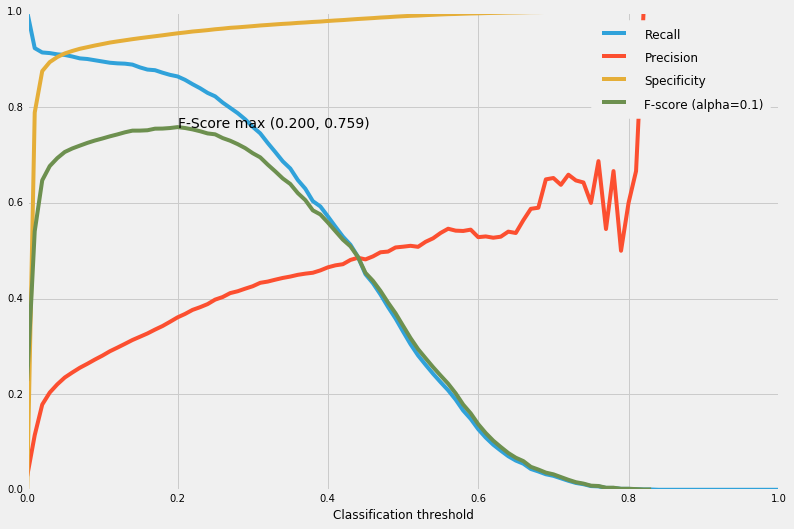

In [593]:
plotCurves(res[0,:], res[1,:], 0.1)

In [594]:
pd.crosstab(res[0,:], res[1,:] > 0.2, rownames=['Click'], colnames=['Prediction'])

Prediction,False,True
Click,,
0.0,49819,2356
1.0,208,1329


In [597]:
res = kFoldValidationVW('--loss_function logistic -b 22', False)

ROC AUC = 0.946911166471


In [602]:
res = kFoldValidationVW('--loss_function hinge', False)

ROC AUC = 0.935893767503


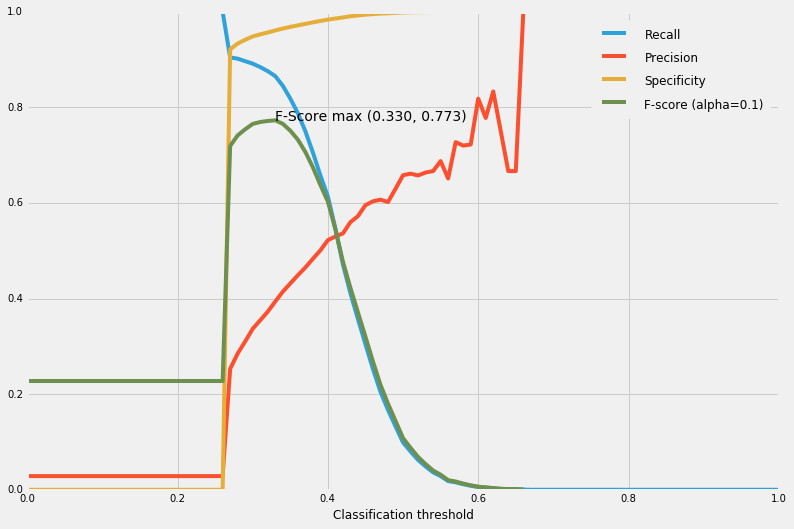

In [600]:
plotCurves(res[0,:], res[1,:], 0.1)

In [601]:
pd.crosstab(res[0,:], res[1,:] > 0.33, rownames=['Click'], colnames=['Prediction'])

Prediction,False,True
Click,,
0.0,50128,2047
1.0,207,1330


In [612]:
res = kFoldValidationVW('--loss_function logistic --passes 10 --cache_file cache.vw', False)

ROC AUC = 0.98547266765


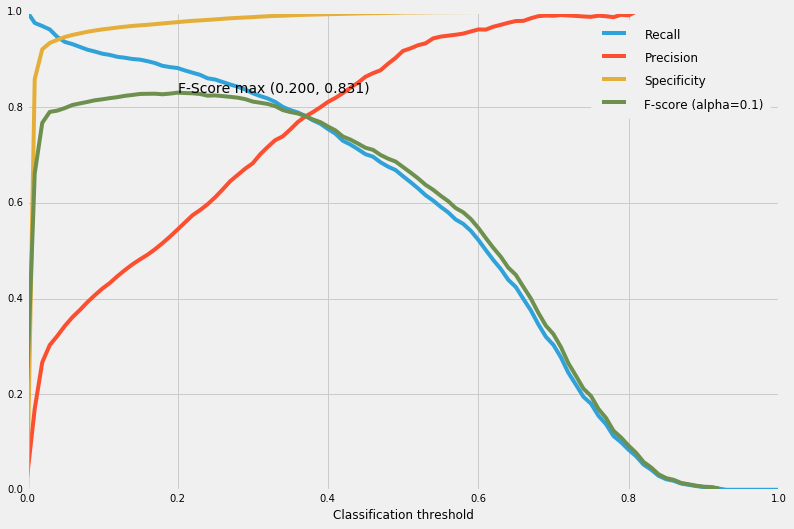

In [613]:
plotCurves(res[0,:], res[1,:], 0.1)

In [614]:
pd.crosstab(res[0,:], res[1,:] > 0.2, rownames=['Click'], colnames=['Prediction'])

Prediction,False,True
Click,,
0.0,51040,1135
1.0,181,1356


In [615]:
res = kFoldValidationVW('--loss_function hinge --passes 10 --cache_file cache.vw', False)

ROC AUC = 0.980340796684


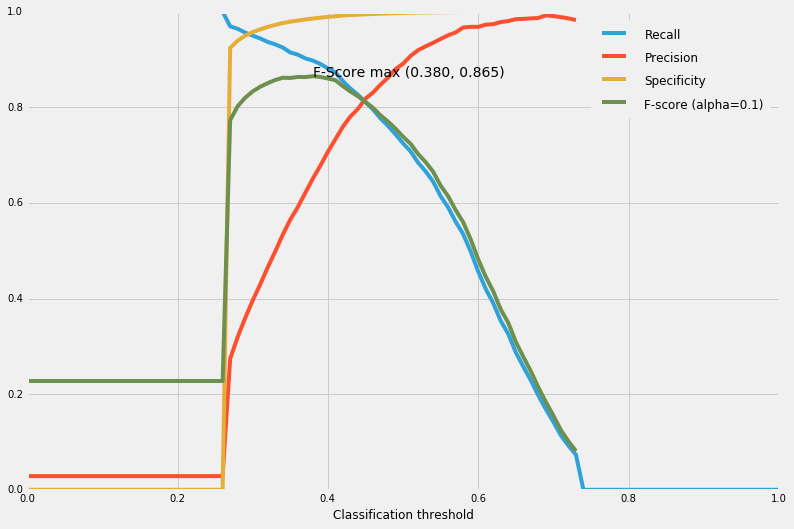

In [616]:
plotCurves(res[0,:], res[1,:], 0.1)

In [618]:
pd.crosstab(res[0,:], res[1,:] > 0.38, rownames=['Click'], colnames=['Prediction'])

Prediction,False,True
Click,,
0.0,51435,740
1.0,157,1380


In [619]:
res = kFoldValidationVW('--loss_function hinge --passes 100 --cache_file cache.vw', False)

ROC AUC = 0.980340796684


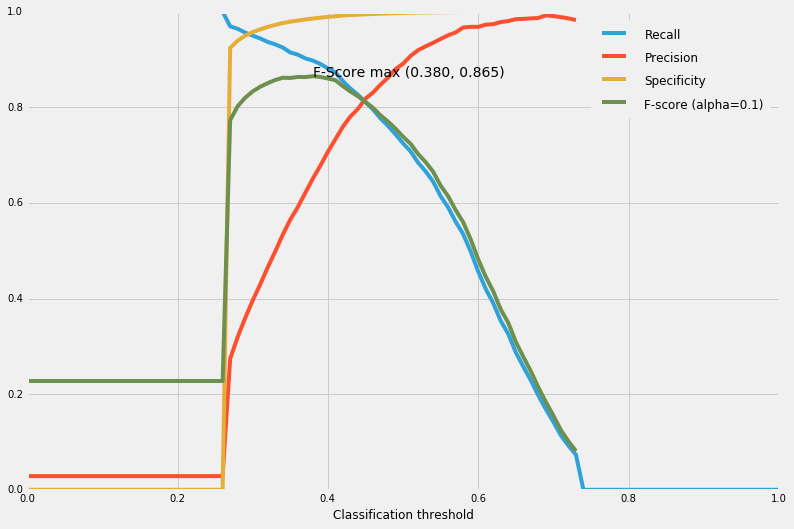

In [620]:
plotCurves(res[0,:], res[1,:], 0.1)

In [621]:
res = kFoldValidationVW('--loss_function logistic --passes 100 --cache_file cache.vw', False)

ROC AUC = 0.987258553508


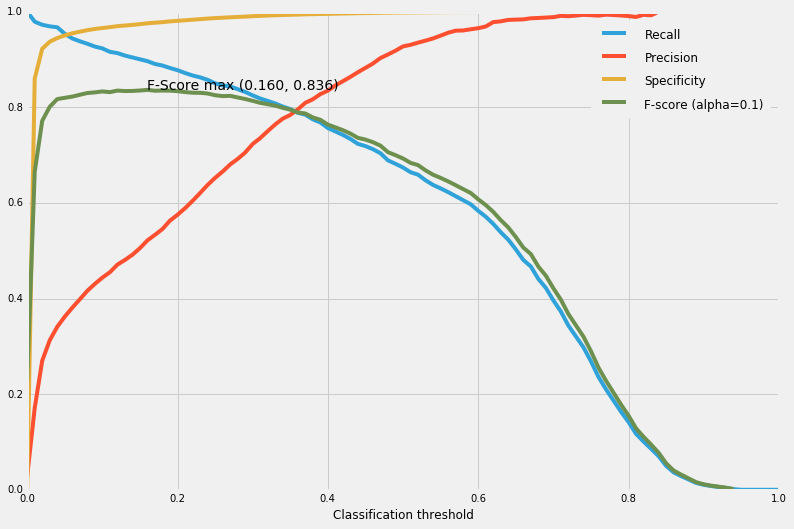

In [622]:
plotCurves(res[0,:], res[1,:], 0.1)

In [624]:
pd.crosstab(res[0,:], res[1,:] > 0.16, rownames=['Click'], colnames=['Prediction'])

Prediction,False,True
Click,,
0.0,50912,1263
1.0,159,1378


So, the best results has '--loss_function hinge --passes 10 --cache_file cache.vw' parameters with threshold = 0.38

Testing on the new data (my test dataset - 20% of edu.log):

In [629]:
print(commands.getoutput('vw srch_test.vw -f model.vw --loss_function hinge --passes 10 --cache_file cache.vw'))
print(commands.getoutput('vw srch_test.vw -t -i model.vw -p pred.txt'))

r = pd.read_table("pred.txt", sep=' ', header=None)
res = np.array([r[1].map(lambda x: raw_train.click[x]), r[0].map(lambda x: 1 / (1 + math.exp(-x)))])

pd.crosstab(res[0,:], res[1,:] > 0.38, rownames=['Click'], colnames=['Prediction'])

final_regressor = model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
using cache_file = cache.vw
ignoring text input in favor of cache input
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  -1.0000   0.0000      528
0.534091 0.068183            2            2.0  -1.0000  -0.9318      528
0.270757 0.007423            4            4.0  -1.0000  -0.9890      528
0.137049 0.003341            8            8.0  -1.0000  -1.0000      528
0.068884 0.000719           16           16.0  -1.0000  -1.0000      528
0.034555 0.000226           32           32.0  -1.0000  -1.0000      528
0.080562 0.126570           64           64.0  -1.0000  -1.0000      528
0.100166 0.119769          128          128.0  -1.0000  -1.0000      528
0.161626 0.223086          256          256.0  -1.0000  -1.000

Prediction,False,True
Click,,
0.0,12693,352
1.0,102,282


Prediction time:

In [631]:
commands.getoutput('vw train.vw -f model.vw --loss_function hinge --passes 10 --cache_file cache.vw')

predTime = time.time()
commands.getoutput('vw test.vw -t -i model.vw -p pred.txt')
predTime = time.time() - predTime
print "Prediction time on test DS: {:.3f} ms".format(predTime * 1000)
print "Time per record: {:.3f} ms".format(predTime * 1000 / raw_test.shape[0])

Prediction time on test DS: 1669.507 ms
Time per record: 0.053 ms


Save predictions to a file:

In [666]:
r = pd.read_table("pred.txt", sep=' ', header=None)
pd.DataFrame([r[1], r[0].map(lambda x: 1 if (1 / (1 + math.exp(-x))) > 0.38 else 0)],
             index=('ID','click')).T.to_csv('Result.csv', index=False, quoting=2)

## Elementwise processing and online learning

The problem that I see is that during online learning the algorithm process only TP and FP records and don't see FN records. It means that the algorithm becomes less addaptive to new patters. Possible solution is to show an advertisement to a little part of unpredicted users and use that data for model testing.

An example of elementwise processing (VW in the daemon mode):

In [632]:
os.system('vw -i model.vw  -t --daemon --quiet --port 26542')

0

In [635]:
def getPrediction(s):
    res = commands.getoutput('echo "' + s + '" | netcat localhost 26542')
    res = float(res.split(' ')[0])
    return 1 / (1 + math.exp(-res))

for i in srch_test.index[:10]:
    print(i, getPrediction(convertDFtoVW(i, srch_test)) > 0.38)

('34-73cf54529c964369bc4cacb0454113ce', False)
('34-45f9162452d54d7680b6a64d0c863a76', False)
('9-8B8970AFBB30ED120F0E75FE13F0C422', False)
('10-8E63179B713B6860F2A3CAECF400813A', False)
('9-DE2582D4658430246DBE69183999B359', False)
('140-718374E31F42F09CFB34D22D5AFD2295', False)
('152-EBE6AA1719CAB321B1AD4C89B2C25ADE', False)
('9-04124FC26CDFA6719B3E8E2E4AEF9A25', False)
('9-1C4E66D9D7C3D03B1F49E3B69B5820E1', False)
('140-744F5F2767A54CB4052178A6036388FA', False)


In [636]:
os.system("pkill -9 -f 'vw.*--port 26542'")

9